<div style="background-image: url('imgs/SoccerField6.jpg'); text-align:center; vertical-align: middle; padding:50px 0; margin-top:30px">
<h1 style="color: white;">Soccer Players Rating</h1>
</div>

### David Yermiyahu | December 2017 | University of Maryland | CMSC 320 - Introduction to Data Science

## Introduction
<img src='https://upload.wikimedia.org/wikipedia/commons/8/80/FIFA_Logo_%282010%29.svg' align='right' width=300/>
Soccer, or as more commonly known outside the US - Football, is a team sport played between two teams of eleven players with a 
spherical ball. It is played by 250 million players in over 200 countries and dependencies, making it the world's most popular sport. The game is played on a rectangular field with a goal at each end. The object of the game is to score by getting the ball into the opposing goal. Association football is governed internationally by the International Federation of Association Football (FIFA), which organises World Cups for both men and women every four years. <font style="font-style: italic; color: gray;">[Wikipedia]</font>

Beacuse of the popularity of the game, a good soccer player can earn a lot of money. For example, the Portuguese player Cristiano Ronaldo, who leads the rating table, made \$93 million in 2017 ($58 million from salary and bonus (before taxes)).

<b>But what makes a player a good one?</b>

As a player, what skills do you need to sharp? As a soccer club, which players you should sign? Kaggle released a "Complete FIFA 2017 Player dataset", which describes the rating alongside diffrent features (skiils and properties) of <b>17,588 players</b>. 

In this tutorial we will try to predict the rating of a player, based on his skills and properties.


## Enviroment Setup
### Prerequisites
To provide some computation and visualisation abilites, some python packages are needed. Please verify you have installed Python 3.5 or above and the following packages. Installing packages can achive by "pip install PACKAGE_NAME" from your terminal.

In [121]:
!pip install folium
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json, os
import sklearn

# this allows plots to appear directly in the notebook
%matplotlib inline

## 1. Data Collection
As menthioned before, we will use the FIFA dataset from Kaggle as our main source. In addition, for our maps we will use geo
location data of countries around the wrold, provided by the Folium's github.

In [100]:
# World countries geo location data
geo_json_data = json.load(open('data/world-countries.json'))

# Load the FIFA soccer players data into a Pandas data frame
data = pd.read_csv("data/FullData.csv", sep=',')
data.head()  # Here are the first 5 (our of 17,588) rows for example

,Name,Nationality,National_Position,National_Kit,Club,Club_Position,Club_Kit,Club_Joining,Contract_Expiry,Rating,...,Long_Shots,Curve,Freekick_Accuracy,Penalties,Volleys,GK_Positioning,GK_Diving,GK_Kicking,GK_Handling,GK_Reflexes
0,Cristiano Ronaldo,Portugal,LS,7.0,Real Madrid,LW,7.0,07/01/2009,2021.0,94,...,90,81,76,85,88,14,7,15,11,11
1,Lionel Messi,Argentina,RW,10.0,FC Barcelona,RW,10.0,07/01/2004,2018.0,93,...,88,89,90,74,85,14,6,15,11,8
2,Neymar,Brazil,LW,10.0,FC Barcelona,LW,11.0,07/01/2013,2021.0,92,...,77,79,84,81,83,15,9,15,9,11
3,Luis Suárez,Uruguay,LS,9.0,FC Barcelona,ST,9.0,07/11/2014,2021.0,92,...,86,86,84,85,88,33,27,31,25,37
4,Manuel Neuer,Germany,GK,1.0,FC Bayern,GK,1.0,07/01/2011,2021.0,92,...,16,14,11,47,11,91,89,95,90,89


## 2. Data Proccessing
Some of the columns in the FIFA dataset are not ready for anayzing. We will remove the mesurment units names and create integer representation columns for categorial columns. In addition, we will fix the nationality values to be fit with the official countries names appear in the geo location data. Finally, the column "Preffered Position" contains all the positions a specific player prefers. We will split those values to separate records (rows) in a new data frame. The original data frame will be used later, when the player position is not required and we will want to work with a smaller dataset (with no duplicate rows).

In [101]:
# Create catagorial lists, used to translate their representation to integer by using thier index.
clubs = data['Club'].unique()
feet = data['Preffered_Foot'].unique()
nationalities = data['Nationality'].unique()
# We gonna use the index of nationality as their integer representation.
# Since the players data is sorted by their rating, the nations index will be sroted that way too.
# Such an order will mislead the reader to see a linear conation between nationality and rating.
nationalities.sort()  # sort alphebetic to avoid 

# ==== Tidy Data ===
# Create colums with integer representation
data['club_id'] = data['Club'].apply(lambda cb: np.where(cb == clubs)[0]).astype(float)
data['nationality_id'] = data['Nationality'].apply(lambda nat: np.where(nat == nationalities)[0]).astype(float)
data['foot_id'] = data['Preffered_Foot'].apply(lambda ft: np.where(ft == feet)[0]).astype(float)
# Remove characters from integer columns
data['Height'] = data['Height'].apply(lambda val: val.split(' ')[0]).astype(float)  # remove 'cm'
data['Weight'] = data['Weight'].apply(lambda val: val.split(' ')[0]).astype(float)  # remove 'kg'

data['Rating'] = data['Rating'].astype(float)
data['Age'] = data['Age'].astype(float)
data.iloc[:, 17:] = data.iloc[:, 17:].astype(float)

# Match the nations names in the players data to the offical names appear on the map.
# The names in the dataset sometimes represents sepcific area or the nickname of the national soccer team.
data['Nationality'] = data['Nationality'].replace('China PR', 'China').astype(str)
data['Nationality'] = data['Nationality'].replace('Chinese Taipei', 'Taiwan').astype(str)
data['Nationality'] = data['Nationality'].replace('United States', 'United States of America').astype(str)
data['Nationality'] = data['Nationality'].replace('Korea DPR', 'North Korea').astype(str)
data['Nationality'] = data['Nationality'].replace('Korea Republic', 'South Korea').astype(str)
data['Nationality'] = data['Nationality'].replace('Republic of Ireland', 'Ireland').astype(str)
data['Nationality'] = data['Nationality'].replace(['Northern Ireland', 'England', 'Bermuda'], 'United Kingdom').astype(str)
data['Nationality'] = data['Nationality'].replace('Trinidad & Tobago', 'Trinidad and Tobago').astype(str)
data['Nationality'] = data['Nationality'].replace('FYR Macedonia', 'Macedonia').astype(str)
data['Nationality'] = data['Nationality'].replace('Central African Rep.', 'Central African Republic').astype(str)
data['Nationality'] = data['Nationality'].replace('Tanzania', 'United Republic of Tanzania').astype(str)
data['Nationality'] = data['Nationality'].replace('Timor-Leste', 'East Timor').astype(str)
data['Nationality'] = data['Nationality'].replace('Bosnia Herzegovina', 'Bosnia and Herzegovina').astype(str)
data['Nationality'] = data['Nationality'].replace('DR Congo', 'Democratic Republic of the Congo').astype(str)
data['Nationality'] = data['Nationality'].replace('Congo', 'Republic of the Congo').astype(str)

In [102]:
# Some players appear to prefer more than one playing position.
# Their different positions apper with a 'slash (/).
# Create new data frame in which every position appear in a different record (row)
# the rest of the fields are copied the same.
df = pd.DataFrame(columns = data.columns)
for i, _ in enumerate(data.values):
    row = data.iloc[i].copy()
    player_positions = row['Preffered_Position'].split('/')
    for pos in player_positions:
        row['Preffered_Position'] = pos
        df.loc[len(df)] = row
        
positions = df['Preffered_Position'].unique()
df['position_id'] = df['Preffered_Position'].apply(lambda ps: np.where(ps == positions)[0]).astype(int)
df['Rating'] = df['Rating'].astype(float)

## Soccer Positions
We will talk a lot about the position (role) of a soccer player on the field. Hence it is important to have a basic idea of what the positions' abbreviations stand for and where do they located the players on the field.
<font style="font-style: italic; color: gray;">
Information and image from [the18.com]
</font>
<img src='http://the18.com/sites/default/files/u100013226/20171004-The18-Image-Field.jpg'
alt='Positions on Field' width=500 align='right'/>

Goalkeeper (GK)

Defenders

- Sweeper (SW)

- Center-back / Center Full-back / Central Defender (CB)

- Right and Left Full-backs (RB/LB)

- Right and Left Wing-backs (RWB/LWB)

Midfielders

- Defensive / Holding Midfielder (DM)

- Center Midfielders (CM)

- Attacking Midfielders (AM)

- Wide Midfielders / Wingers (RW/LW)

Forwards

- Center Forward (CF)

- Second Forward / Second Striker / Support or Withdrawn Striker (CF or S)

- Striker (S or ST)

## 3. Exploratory Analysis & Data Vizualization
### Does a position of a player affect his rating?
The following boxplot shows that the rating of a player mostly doesn't depend on his role on the field. Every player regardless of his position can be popular. With that being said, you can notice that highest values were achived by Wingers (RW/LW), Striker (ST) and the Goalkeeper (GK). It can be explained by the fact that these positions are usually associated with scoring or fighting off a goal - excited moments and the main aim of the game.

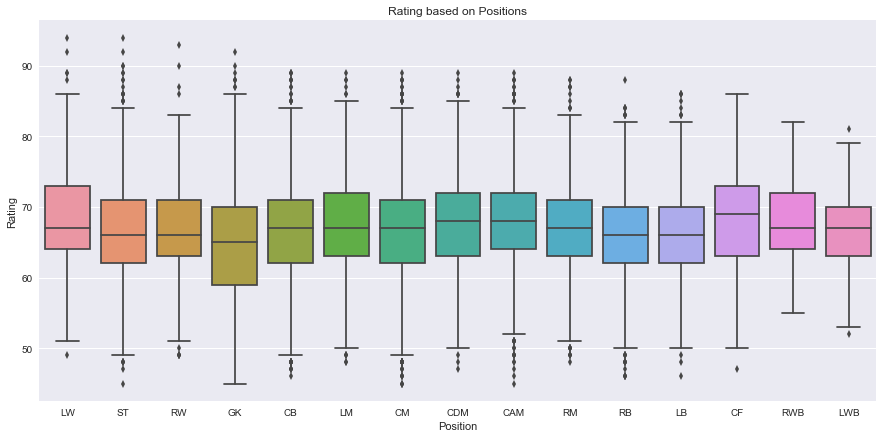

In [103]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(x='Preffered_Position', y='Rating', data=df, ax=ax)
plt.xlabel('Position'); plt.ylabel('Rating'); plt.title("Rating based on Positions");

### Does abilities or properties of a player affect his rating?
A player can be ranked on different kind of properties like age, height or weight; and game abilities like speed, jumping, etc.
Different features have stronger, weaker or none effect on the player ranking. Some of them affect all kind of the positions players, some of them just a few.

Please note that we duplicated the records to contain just one <i>preffered position</i> each time, hence the graph supposed to contain several points that represents the same player. But, because we didn't touch the other features (like rating and reactions in this case) all the player's points will be placed on the exact same location, hence us as readers, will still see at most one point for each players (some players cover others).

The dataset contains <b>52 feautres</b>, hence just some of them will be presented as an example.
An example for a feature which has a correlation with the player's rating (in all positions) is the <i>reactions</i>.
Each point on the graph is colored by the player preffered position. We can notice the the points are grouped together to create a daigonal line which shows that the more reactive the player is, the higher raiting he gets.

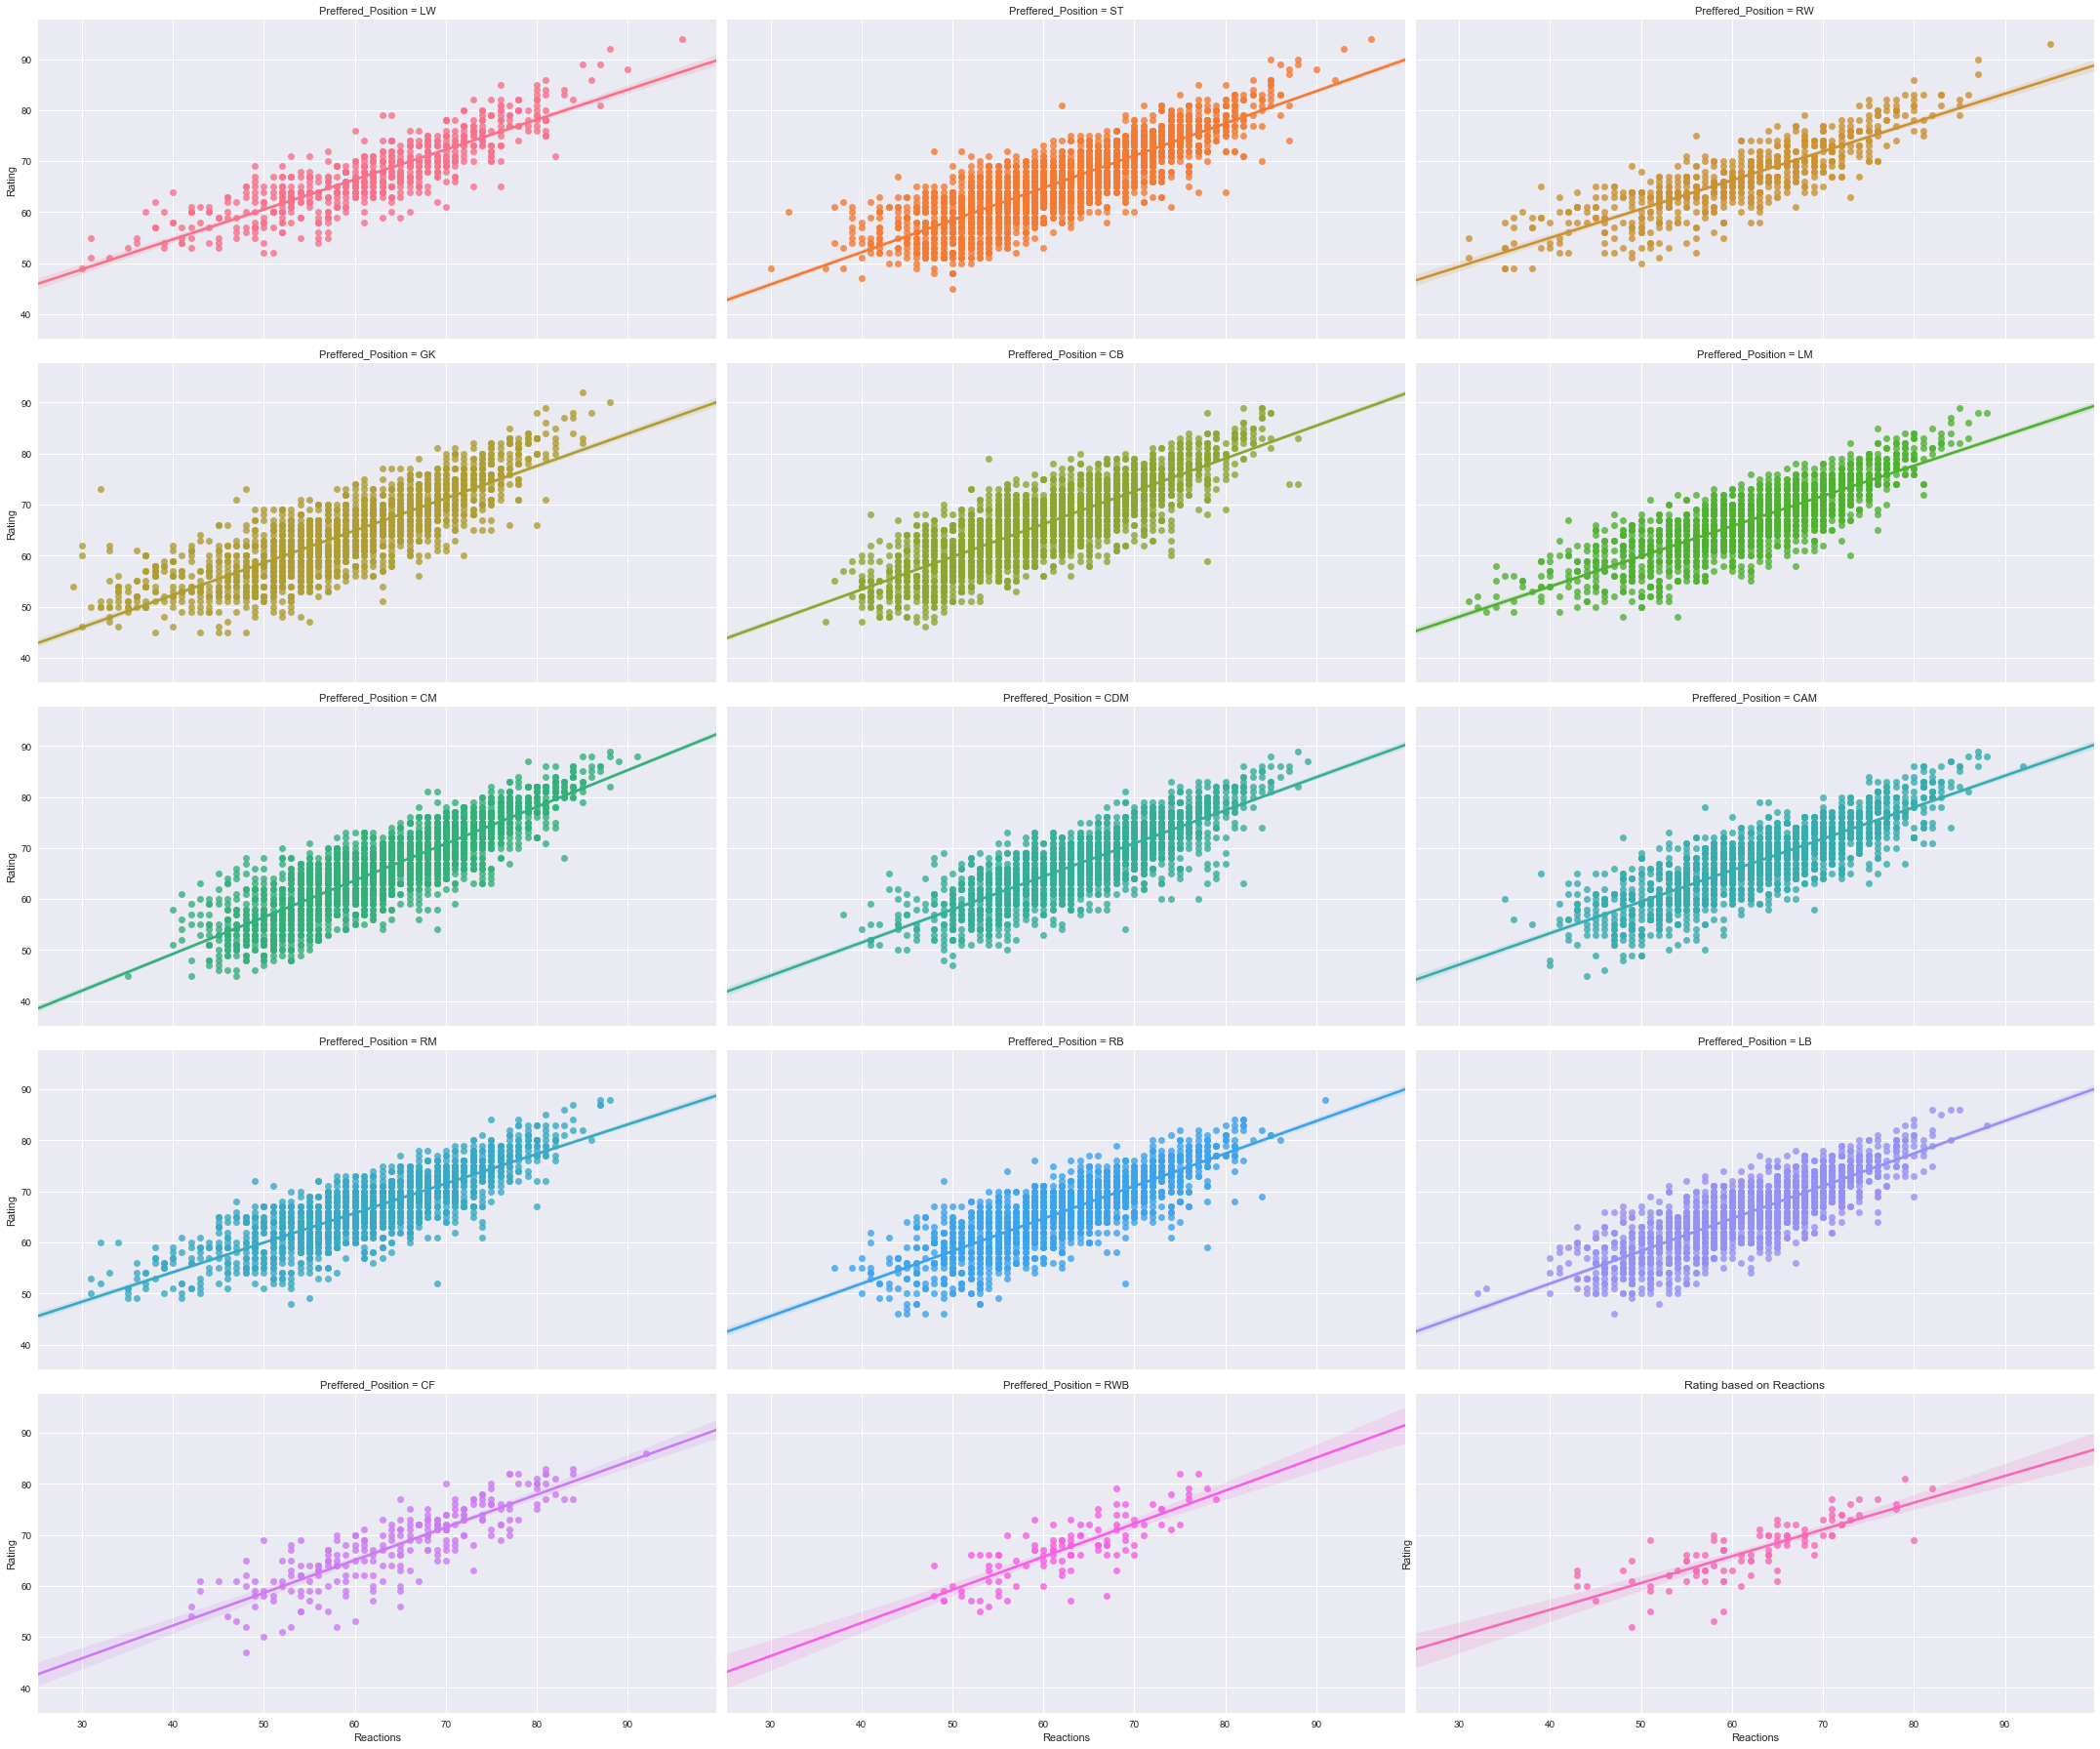

In [104]:
graph = sns.lmplot('Reactions', 'Rating', data=df, size=5, aspect=2, fit_reg=True, hue='Preffered_Position',
                  col='Preffered_Position', col_wrap=3, scatter=True)
plt.xlabel('Reactions'); plt.ylabel('Rating'); plt.title("Rating based on Reactions");

Examples for features with no correlation to rating are age, height or weight. An interseting notice about the following graph is that regardless to their rating, gate keepers (GK) intend to weight more. It could be explained by the fact that their position does not require a lot of running or it may help them to keep on a steady standing or cover more space of the gate (just kidding).

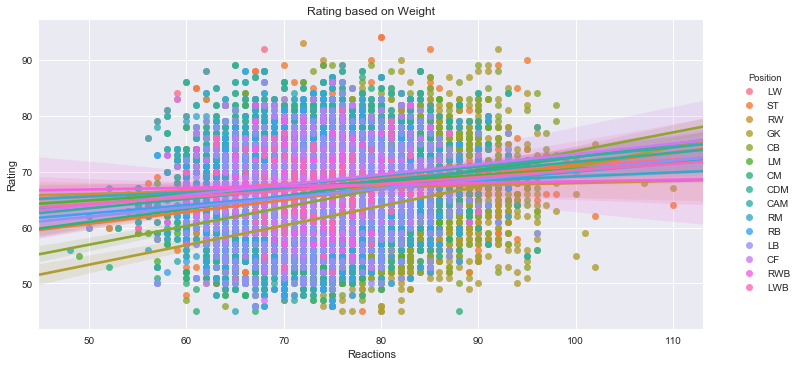

In [105]:
# Similar results are accpted for Rating based on Height
graph = sns.lmplot('Weight', 'Rating', data=df, size=5, aspect=2, fit_reg=True, hue='Preffered_Position')
graph._legend.set_title('Position'); plt.xlabel('Reactions'); plt.ylabel('Rating'); plt.title("Rating based on Weight");

Some features have corralation to rating just for part of the position players. As the following graph show, the more ball contorl a player (which is not a gate keeper) has to more rating he got. Gate keepers don't run with the ball, hence it is not relevent how good they are controling the ball. We can notice that most of the gate keepers have a low ball control ability, still they have different levels of rating. Similarly, the second graph shows that "GK Reflexes" has strong correlation to gate keepers' rating, while no effect on the other position players.

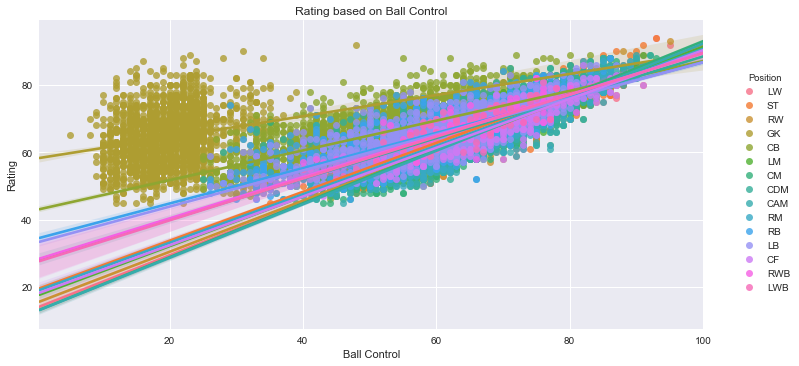

In [106]:
# Similar results are accpted for Rating based on Short Pass
graph = sns.lmplot('Ball_Control', 'Rating', data=df, size=5, aspect=2, fit_reg=True, hue='Preffered_Position')
graph._legend.set_title('Position'); plt.xlabel('Ball Control'); plt.ylabel('Rating'); plt.title("Rating based on Ball Control");

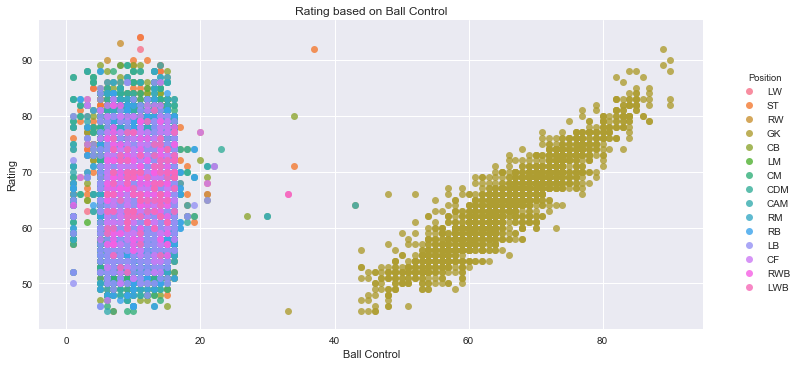

In [107]:
# This graph shows clearly the features effect also without the regression line.
df['GK_Reflexes'] = df['GK_Reflexes'].astype(float)
graph = sns.lmplot('GK_Reflexes', 'Rating', data=df, size=5, aspect=2, fit_reg=False, hue='Preffered_Position')
graph._legend.set_title('Position'); plt.xlabel('Ball Control'); plt.ylabel('Rating'); plt.title("Rating based on Ball Control");

### Does nationality of a player affect his rating?
The following grpah shows that rating does not depnd on nationality. In addition, the graph shows that players from diffrent nations can play in every position.

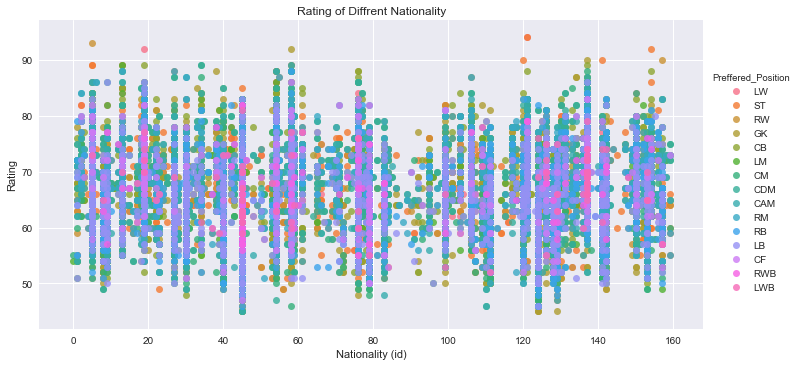

In [83]:
sns.lmplot('nationality_id', 'Rating', data=df, size=5, aspect=2, fit_reg=False, hue='Preffered_Position')
plt.xlabel('Nationality (id)'); plt.ylabel('Rating'); plt.title("Rating of Diffrent Nationality");

The following maps show the median rating and the amount of players from each nation.

Darker color represents higher value, as the legend implies. Coutries like Greenland and Faroe Islands are not members of FIFA nor of any continental confederation and therefore are not eligible to enter the World Cup or other sanctioned tournaments. As a results countries like those appear with a very bright color.

Notable example on the maps is United Kingdom. Althogh it has the largest amount of players on the dataset, its median rating is considered low.

In [16]:
# Create the data frame for the map coloring
groped = data[['Nationality', 'Rating']].groupby(['Nationality'])
meadian = data[['Nationality', 'Rating']].groupby(['Nationality']).median()
nat_des = groped.describe()

nats = pd.DataFrame()
nats['count'] = groped.size()
nats['mean'] = nat_des['Rating']['mean']
nats['median'] = meadian
nats['max'] = nat_des['Rating']['max']
nats['nationality'] = nats.index
nats.head()

,count,mean,median,max,nationality
Nationality,,,,,
Afghanistan,2,54.500000,54.5,55.0,Afghanistan
Albania,37,65.864865,67.0,79.0,Albania
Algeria,50,71.620000,71.0,84.0,Algeria
Angola,11,70.000000,69.0,77.0,Angola
Antigua & Barbuda,4,62.500000,62.0,66.0,Antigua & Barbuda


In [17]:
nat_avg_map = folium.Map(location=[30, 0], zoom_start=1.5, tiles='Mapbox Bright')
nat_avg_map.choropleth(
    geo_data=geo_json_data,
    data=nats,
    columns=['nationality', 'median'],
    key_on='feature.properties.name',
    fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
    legend_name='Rating Median'
    )

nat_count_map = folium.Map(location=[30, 0], zoom_start=1.5, tiles='Mapbox Bright')
nat_count_map.choropleth(
    geo_data=geo_json_data,
    data=nats,
    columns=['nationality', 'count'],
    key_on='feature.properties.name',
    fill_color='OrRd', fill_opacity=0.7, line_opacity=0.2,
    legend_name='Players Amount'
    )

nat_avg_map  # Rating Average

In [18]:
nat_count_map  # Players Amount

## 4. Hypothesis Testing & ML
### Hypothesis
As discussed above, our assumption is that there is a dependency between the player ablilities and properties to his rating. Hence we will define the null hypothesis to be "There is <b>no</b> dependency between the player ablilities and properties to his rating", since we belive we can reject it (We are not allowed to accpet a null hypothesis).


### Machine Learning
We will want to harness the power of ML to try to classify and predict the rating of a soccer player, and by so, his success. By choosing ML algorithms and turning their hyper paramerters, we can test and check whether the raiting predication is possible - with prbability to be right above 50% (better than a guess).

<img src='imgs/safety.jpg' width=200 align='right'/>

But first things first...

#### Preparing Data
We are going to train 2 supervised machine learning models to predict the rating of a player. The model are supervised since we supplied them both the features and the right answer - the rating.

The rating currently ranges from 0 to 100, allowing 101 different values to predict. In order to simplify the predication, we will narrow the range to be from 0 to 10, by creating a new column for the rating labels.

In [119]:
df['Rating_Label'] = df['Rating'].apply(lambda rt: round(rt/10)).astype(int)
idx = np.random.choice(range(len(df)), size=5, replace=False)
df[['Name', 'Rating', 'Rating_Label']].iloc[idx].head()

,Name,Rating,Rating_Label
827,Gayà,79.0,8
11076,Stef Nijland,68.0,7
709,Danny Drinkwater,80.0,8
24769,Sean Heaney,53.0,5
8550,Django Warmerdam,69.0,7


Obviously we don't want to provide the rating columns themselves as features to relay on, and also don't want to add mislead features like height or weight. Hence, the features that will be provided to the models are:

In [120]:
df.iloc[:, 17:-1].columns  # the last column is the "Rating_Label" that we have just added.

Index(['Weak_foot', 'Skill_Moves', 'Ball_Control', 'Dribbling', 'Marking',
       'Sliding_Tackle', 'Standing_Tackle', 'Aggression', 'Reactions',
       'Attacking_Position', 'Interceptions', 'Vision', 'Composure',
       'Crossing', 'Short_Pass', 'Long_Pass', 'Acceleration', 'Speed',
       'Stamina', 'Strength', 'Balance', 'Agility', 'Jumping', 'Heading',
       'Shot_Power', 'Finishing', 'Long_Shots', 'Curve', 'Freekick_Accuracy',
       'Penalties', 'Volleys', 'GK_Positioning', 'GK_Diving', 'GK_Kicking',
       'GK_Handling', 'GK_Reflexes', 'club_id', 'nationality_id', 'foot_id',
       'position_id'],
      dtype='object')

In order to uderstand the quality of the prediction the models have to be tested. They cann't be tested on the data they have just trained on (like in real life) - it will be meaningless. Hence We are going to split our data into traing and testing data. It is common to save 30% of the original data for testing. To keep the distribution of the two data sets similar as much as we can, the records will be divided randomly.

In [55]:
from sklearn.metrics import accuracy_score, r2_score

TEST_PERCENTAGES = 0.3  # save 30% of the data for testing

# Figure out how many records is it 30%
test_size = np.floor(len(df) * TEST_PERCENTAGES).astype(int)  
print('Saving aside %d (%d%%) out of %d records for testing' % (test_size, TEST_PERCENTAGES*100, len(df)))
# Choose randomly indexes in that amount to be the test data set
test_idx = np.random.choice(range(len(df)), size=test_size, replace=False)

test_records = df.iloc[test_idx]
X_test = test_records.iloc[:, 17:-1]  # Take the features columns only
y_test = test_records['Rating_Label']

# Save to training all the rest (70%) of the records
training = df[~df.index.isin(test_records.index)]
X_train = training.iloc[:, 17:-1]  # Take the features columns only
y_train = training['Rating_Label']

Saving aside 7637 (30%) out of 25458 records for testing


Last but not least, before we can start training the models we need to tune them. Each model has its own parameters which initialize it and determine the way it work - the <b>Hyperparameters</b>.

Allegedly, we can try different hyperparameters values and choose the ones which provide better test results. But, doing so will cause <b>overfitting</b> - a situation in which the models become to be depend too much on the very specific data we have now. Since we have only a sample of the world - not all of its data, trying to predict rating according to combination of features values the models didn't see before will fail miserably.

To avoid that, we will preform <b>cross validation</b>. The training data set will be split again, this time to 10 chunks. Each time the model set with different hyperparameters, being trained on the current training set, and immediately being tested on the corresponding validation set. At the end we can choose the best classifier (trained model) as the final result which will be tested on the official test data set.

In [ ]:
NUM_OF_CROSS_VALIDATION = 10

# divide the training to train and validation sets (corss-validation times)
validation_idx = np.arange((len(training) // NUM_OF_CROSS_VALIDATION) * NUM_OF_CROSS_VALIDATION).reshape(NUM_OF_CROSS_VALIDATION, -1)

#### Train the models
I chose the algorithms Random Forests and K-NN, since our features contain numeric values (continous and categorial) which will be good points for splitting the trees' branches or for grouping neighbors. In addition I worked with these algorithms in the past and have some experience. We have 11 levels of rating (0-10 inclusive), hence I decided to initialize the forest with 5 (~half of 11) estimators and to define k=5 for K-NN as well.

Allegedly, choosing higher numbers will allow the models to be more accurate, but that will lead to overfit again. From some point the models will no longer train to predict rating, they would just succeed to memorize it instead.

In [194]:
# ========== Random Forests ==========
from sklearn.ensemble import RandomForestClassifier

frst_scores = []
frst_clfs = []

for valid_idx in validation_idx:  # for each cross validation
    X_valid = np.take(X_train, valid_idx, axis=0)
    y_valid = np.take(y_train, valid_idx, axis=0)
    X = X_train[~X_train.index.isin(X_valid.index)]
    y = y_train[~y_train.index.isin(y_valid.index)]
    
    # Train a random forest of 5 default decision trees
    frst_clf = RandomForestClassifier(n_estimators=5)
    # fitting the model
    frst_clf.fit(X, y)

    # predict the response
    frst_pred = frst_clf.predict(X_valid)
    score = accuracy_score(y_valid, frst_pred)
    frst_scores.append(score)
    frst_clfs.append(frst_clf)

print('Cross Validations Scores:\n' + str(['%.2f' % (x) for x in frst_scores]))
best_score_idx = np.argmax(frst_scores)
best_frst_clf = frst_clfs[best_score_idx]

# evaluate test accuracy
frst_test_pred = best_frst_clf.predict(X_test)
frst_test_score = accuracy_score(y_test, frst_test_pred)
print('Accuracy Test Score: %0.4f%%' % (frst_test_score * 100))
print('Regression Test Score: %0.4f%%' % (r2_score(y_test, frst_test_pred) * 100))

Cross Validations Scores:
['0.51', '0.75', '0.96', '0.95', '0.79', '0.61', '0.62', '0.91', '0.96', '0.50']
Accuracy Test Score: 90.3889%
Regression Test Score: 84.1311%


In [200]:
# ========== K-NN Classification ==========
from sklearn.neighbors import KNeighborsClassifier

knn_scores = []
knn_clfs = []

for valid_idx in validation_idx:  # for each cross validation
    X_valid = np.take(X_train, valid_idx, axis=0)
    y_valid = np.take(y_train, valid_idx, axis=0)
    X = X_train[~X_train.index.isin(X_valid.index)]
    y = y_train[~y_train.index.isin(y_valid.index)]
        
    # instantiate learning model (k = 5)
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    # fitting the model
    knn_clf.fit(X, y)

    # predict the response
    knn_pred = knn_clf.predict(X_valid)
    score = accuracy_score(y_valid, knn_pred)
    knn_scores.append(score)
    knn_clfs.append(knn_clf)

print('Cross Validations Scores: ' + str(['%.2f' % (x) for x in knn_scores]))
best_score_idx = np.argmax(knn_scores)
best_knn_clf = knn_clfs[best_score_idx]

# evaluate test accuracy
knn_test_pred = best_knn_clf.predict(X_test)
knn_test_score = accuracy_score(y_test, knn_test_pred)
print('Accuracy Test Score: %0.4f%%' % (knn_test_score * 100))
print('Regression Test Score: %0.4f%%' % (r2_score(y_test, knn_test_pred) * 100))

Cross Validations Scores: ['0.22', '0.71', '0.87', '0.83', '0.63', '0.58', '0.53', '0.79', '0.88', '0.50']
Accuracy Test Score: 79.9529%
Regression Test Score: 66.9058%


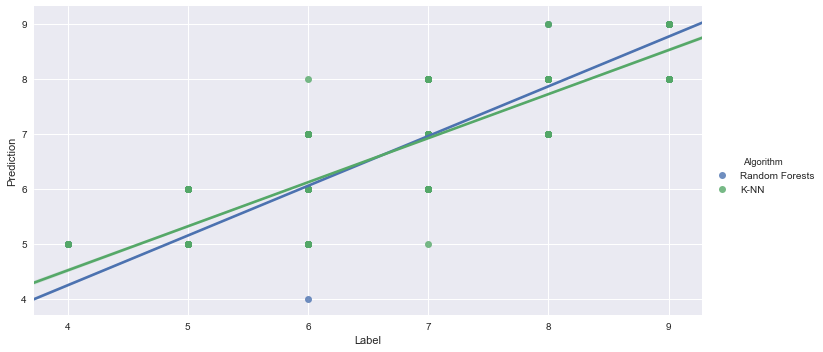

In [201]:
frst_df = pd.DataFrame({'Label': y_test, 'Prediction': frst_test_pred, 'Algorithm': ['Random Forests']*len(y_test)})
knn__df = pd.DataFrame({'Label': y_test, 'Prediction': knn_test_pred, 'Algorithm': ['K-NN']*len(y_test)})
res_df = pd.concat([frst_df, knn__df], axis=0)
graph = sns.lmplot('Label', 'Prediction', data=res_df, size=5, aspect=2, fit_reg=True, hue='Algorithm')

## 5. Conclustion
We can definitely reject our null hypothesis. Our models did a pretty good job in predicting the players rating, with accuracy of 80% and 90% for K-NN and Rain Forest respectively. In general, the higher the R-squared, the better the models fit the data. The regression score is more close to 100% than 0% which imply on correltion. In addition we can notice to the regression lines on the last graph and how they describe a correlation with their diagonal direction.

It seems that the rating of a soccer player depends on his abilities on the field and can be predicted. So if you want to be popular and earn money from your hobby, you better start to get into shape.

Thanks for reading,<br/>
David.

## Read More
* <a href='https://en.wikipedia.org/wiki/Association_football'>Wikipedia: Soccer</a>
* <a href='https://www.fifa.com/'>FIFA's official website</a>
* <a href='http://www.businessinsider.com/the-best-footballers-in-the-world-ronaldo-messi-neymar-2017-8/'>Business Insider: The 24 best footballers on the planet right now</a>
* <a href='https://www.topdrawersoccer.com/college-soccer/college-national-top-100/men/2017'>College Soccer Player Rankings - National</a>

## Resources
* Soccer players data - "Complete FIFA 2017 Player dataset (Global)" - <a href='https://www.kaggle.com/artimous/complete-fifa-2017-player-dataset-global'>kaggle.com</a>
* Soccer position information - <a href='http://the18.com/soccer-learning/soccer-positions-explained-names-numbers-and-roles'>http://the18.com</a>
* World countries visualization - <a href='https://github.com/python-visualization/folium/tree/master/examples/data'>folium's github</a>

<div style="background-image: url('imgs/SoccerField6.jpg'); text-align:center; vertical-align: middle; padding:50px 0; margin-top:30px">
<h1 style="color: white;">Good Luck!</h1>
</div>
